### Overview 
One factor rarely considered when generating machine learning (ML) predictions for small molecules in drug discovery is the influence of tautomers on the predictions. Tautomers have differing molecular connectivity and will generate different molecular representations. This is true regardless of whether an ML model is generated from molecular fingerprints, topological descriptors, or a message-passing neural network (MPNN). These different representations can generate different predicted values from an ML model. However, it should also be noted that ML predictions are also a function of the molecules used to train the ML model. Different train/test splits will produce different predictions for the same molecule. I was curious whether the influence of tautomers on an ML prediction was more significant than that of the training set.

To investigate this, I compared the prediction variability over 10 train/test splits with the variability introduced by making predictions on dissimilar tautomers. I performed 10 train/test splits of the same dataset and collected the test set predictions. Since we performed a random split, the training and test set composition changed at each iteration. As such, the same molecule could potentially different predicted value at each iteration. Since we performed a 75/25 train/test split, each molecule was tested an average of 2.6 times during the 10 iterations.

As a comparator, I generated the two most different tautomers for each molecule and generated a Morgan fingerprint for each. I then repeated the 10 train/test splits and calcuated the difference between the values predicted for each tautomer at each iteration. After these calculations, we will have two distributions.
1. A collection of deltas over 10 train/test splits
2. A collection of prediction deltas for tautomer pairs
   
Finally, I compared the prediction range (max-min) over 10 train/test splits with the average prediction difference between two tautomers over 10 iterations. By plotting these distributions, we can understand whether prediction changes due to tautomer differences are larger than changes due to training set composition.


In [37]:
import pandas as pd
import useful_rdkit_utils as uru
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from lightgbm import LGBMRegressor
import numpy as np
import seaborn as sns
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, DataStructs
from itertools import combinations
from rdkit import rdBase
import warnings
from scipy.stats import ttest_ind

### Support Functions
A simple wrapper around the RDKit tautomer generation capability. 

In [49]:
class TautomerGenerator:
    def __init__(self):
       self.enumerator = rdMolStandardize.TautomerEnumerator()

    def get_canonical_tautomer_smiles(self, smi):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            can_taut_mol = self.enumerator.Canonicalize(mol)
            return Chem.MolToSmiles(can_taut_mol)
        return None

    def get_tautomer_smiles(self, smi):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            tauts = self.enumerator.Enumerate(mol)
            return [Chem.MolToSmiles(x) for x in tauts]
        return None

    def get_least_similar_tautomer_pair(self, smi):
        smi_list = self.get_tautomer_smiles(smi)
        fpgen = uru.Smi2Fp()
        fp_list = [fpgen.get_fp(x) for x in smi_list]
        min_sim = 1.0
        min_smiles = [smi,smi]
        for (fp_a,smi_a), (fp_b,smi_b) in combinations(zip(fp_list,smi_list),2):
            sim_val = DataStructs.TanimotoSimilarity(fp_a,fp_b)
            if sim_val < min_sim:
                min_sim = sim_val
                min_smiles = [smi_a,smi_b]
        return [min_sim] + min_smiles + [len(smi_list)]

    def pandas_canonical_tautomers(self, df, smiles_col="SMILES"):
        tautomer_data = df[smiles_col].progress_apply(self.get_canonical_tautomer_smiles).to_list()        
        name_list = ["canonical_tautomer_SMILES"]
        return pd.DataFrame(tautomer_data,columns=name_list) 

    def pandas_least_similar_tautomers(self, df, smiles_col="SMILES"):
        tautomer_data = df[smiles_col].progress_apply(self.get_least_similar_tautomer_pair).to_list()
        name_list = ["tautomer_sim","taut_SMILES_1","taut_SMILES_2","num_tautomers"]
        return pd.DataFrame(tautomer_data,columns=name_list) 

A simple function to train a machine learning models and store the results in the **test** dataframe. 

In [ ]:
def build_lgbm_model(train, test, descriptor_col, truth_col, result_col):
    model = LGBMRegressor(verbose=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(np.stack(train[descriptor_col]), train[truth_col])
        test[result_col] = model.predict(np.stack(test[descriptor_col]), truth_col)

Enable progress bars in Pandas

In [3]:
tqdm.pandas()

Read the input data

In [51]:
df = pd.read_csv("biogen_logS.csv")

### 1. Generate 10 Sets of Machine Learning Predictions
In the next section we will compare the variation in predictions for the same molecule over diffent training and test set splits.  We will start with a dataset containing measured solubilities for 2,173 molecules.  This dataset was taken from a [2023 paper](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.3c00160) by Cheng Fang and coworkers at Biogen. We will perform 10 train/test splits and collect the test set predictions for each split.  With this data in hand, we will calcuate the number of times each molecule was predicted as well as the difference (delta) between the maximum and minimum predicted value for each molecule. 

Generate Morgan fingerprints for each molecule

In [5]:
smi2fp = uru.Smi2Fp()
df['fp'] = df.SMILES.apply(smi2fp.get_np_counts)

Perform 10 train/train test splits and collect the test set from 10 cycles. 

In [6]:
test_df_list = []
for i in tqdm(range(0,10)):
    train, test = train_test_split(df)
    test = test.copy()
    build_lgbm_model(train, test, "fp", "logS", "pred")
    test_df_list.append(test)

  0%|          | 0/10 [00:00<?, ?it/s]

Combine the test sets into one dataframe. 

In [7]:
combo_df = pd.concat(test_df_list)

Compute the maximum and minimum predicted value for each test set molecule. 

In [8]:
delta_list = []
for k,v in combo_df.groupby("Internal ID"):
    if len(v) > 0:
        delta = max(v.pred) - min(v.pred)
        delta_list.append([k,len(v),delta])

Put the information collected above into a dataframe  
**name** - the molecule name  
**num** - the number of times the molecule was used in a test set  
**deta** - the difference between the highest and lowest predicted values  

In [24]:
single_delta_df = pd.DataFrame(delta_list,columns=["name","num","delta"])
single_delta_df['dataset'] = 'single'

Plot the number of times each molecule was used over 10 cycles. 

In [53]:
single_delta_df.num.mean()

2.6484907497565726

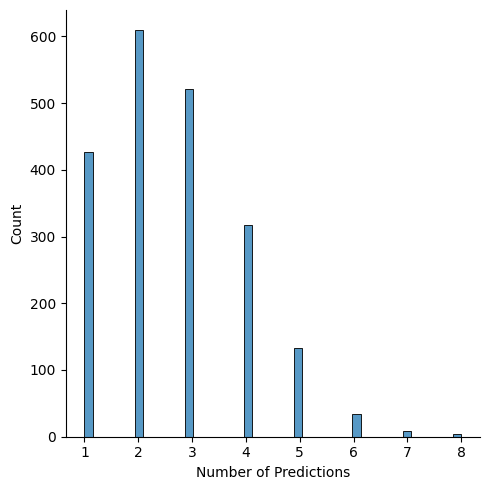

In [87]:
ax = sns.displot(single_delta_df.num)
ax.axes[0][0].set_xlabel("Number of Predictions");

Plot the deltas 

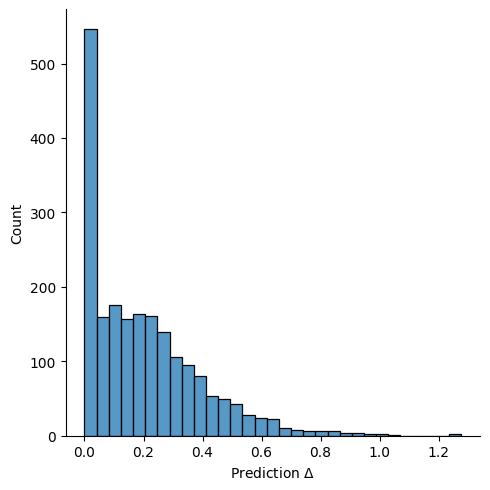

In [86]:
ax = sns.displot(single_delta_df.delta)
ax.axes[0][0].set_xlabel("Prediction $\Delta$");

### 2. Compare ML Model Predictions for Tautomers
In this section, we will generate a pair of dissimilar tautomers for each molecule.  We will then generate fingerprints and ML model predictions for each of the tautomers.  We then record the difference (delta) between the predictions for the tautomers. 


Instantiate a TautomerGenerator

In [12]:
tautomer_generator = TautomerGenerator()

Generate the least similar tautomer pair for each molecule

In [13]:
with rdBase.BlockLogs():
    taut_df = tautomer_generator.pandas_least_similar_tautomers(df)

  0%|          | 0/2173 [00:00<?, ?it/s]

Generate fingerprints for the Tautomers 

In [14]:
taut_df["taut_fp_1"] = taut_df.taut_SMILES_1.progress_apply(smi2fp.get_np_counts)
taut_df["taut_fp_2"] = taut_df.taut_SMILES_2.progress_apply(smi2fp.get_np_counts)

  0%|          | 0/2173 [00:00<?, ?it/s]

  0%|          | 0/2173 [00:00<?, ?it/s]

Get model predictions for each of the tautomers and store the difference between the predictions in **taut_pred_delta**.  Repeat this 10 times. 

In [68]:
taut_df_list = []
for i in tqdm(range(0,10)):
    taut_df["logS"] = df.logS
    taut_df["Internal ID"] = df["Internal ID"]
    train, test = train_test_split(taut_df)
    test = test.copy()
    build_lgbm_model(train, test, "taut_fp_1", "logS", "taut_pred_1")
    build_lgbm_model(train, test, "taut_fp_2", "logS", "taut_pred_2")
    test["taut_pred_delta"] = np.abs(test.taut_pred_1 - test.taut_pred_2)
    taut_df_list.append(test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [64]:
test.head(3)

,tautomer_sim,taut_SMILES_1,taut_SMILES_2,num_tautomers,taut_fp_1,taut_fp_2,logS,Internal ID,taut_pred_1,taut_pred_2,taut_pred_delta
1555,0.392857,CN(C)C(=O)Cn1cc(C(=O)O)ccc1=O,CN(C)C(O)=Cn1cc(C(=O)O)ccc1=O,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.323252,Mol1634,1.950951,1.976309,0.025358
919,1.000000,NCc1cccnc1OCc1ccccc1,NCc1cccnc1OCc1ccccc1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.406370,Mol998,1.482414,1.561304,0.078890
44,0.337209,O=C(c1ccncc1)N1CCN=C(O)C1c1ccccc1Cl,O=C(c1ccncc1)N1CCNC(O)=C1c1ccccc1Cl,3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.645422,Mol61,1.550442,1.502149,0.048292


Concatenate the tautomer predictions into a single dataframe. 

In [17]:
taut_combo_df = pd.concat(taut_df_list)

Get the average tautomer prediction delta for each molecule. 

In [54]:
result_list = []
for k,v in taut_combo_df.groupby("Internal ID"):
    result_list.append([k,len(v),v.taut_pred_delta.mean()])

In [55]:
tautomer_delta_df = pd.DataFrame(result_list,columns=["name","num","delta"])
tautomer_delta_df['dataset'] = 'tautomer'

How many times was each molecule evaluated in the tautomer predictions. 

In [66]:
tautomer_delta_df.num.mean()

2.6459143968871595

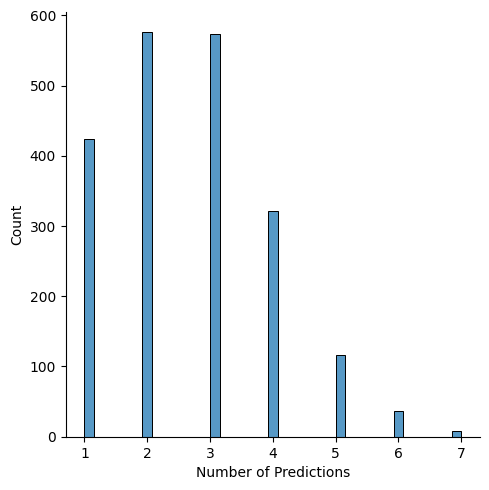

In [85]:
ax = sns.displot(tautomer_delta_df.num)
ax.axes[0][0].set_xlabel("Number of Predictions");

Plot the distribution of tautomer deltas

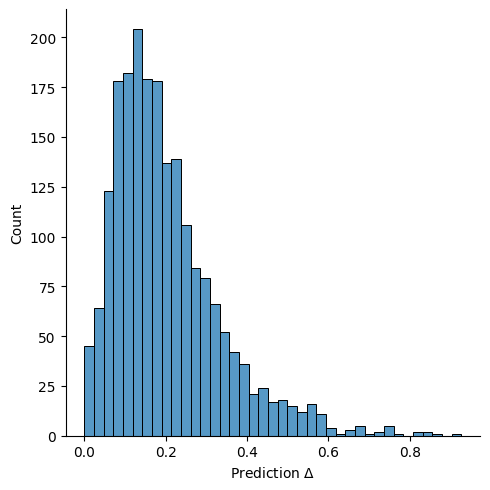

In [82]:
ax = sns.displot(tautomer_delta_df.delta)
ax.axes[0][0].set_xlabel("Prediction $\Delta$");

### 3. Compare Prediction Deltas for Single Molecule Predictions and Tautomer Pair Predictions

Concatenate the single predictions and tautomer predictions. 

In [69]:
combo_delta_df = pd.concat([single_delta_df,tautomer_delta_df])

Use a boxplot to compare delta distributions for single molecule predictions and tautomer deltas. 

Text(0, 0.5, 'Prediction $\\Delta$')

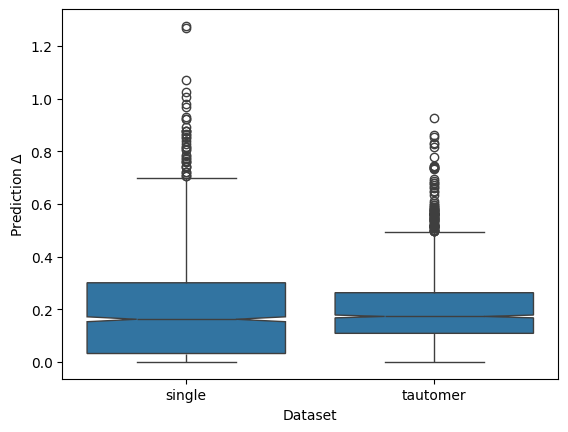

In [71]:
ax = sns.boxplot(x="dataset",y="delta",data=combo_delta_df,notch=True)
ax.set_xlabel("Dataset")
ax.set_ylabel("Prediction $\Delta$")

This difference is not statistically signficant.

In [60]:
single_deltas = combo_delta_df.query("dataset == 'single'").delta
tautomer_deltas = combo_delta_df.query("dataset == 'tautomer'").delta
ttest_ind(single_deltas, tautomer_deltas)

TtestResult(statistic=-0.8216664321287873, pvalue=0.41131445244181375, df=4108.0)

In [61]:
single_deltas.mean(),tautomer_deltas.mean()

(0.19860660707184785, 0.20283822362665455)